In [1]:
# collapsed NNGP 

import numpy as np 
import pandas as pd
import scipy.sparse  as ss
from scipy import stats 

from pypolyagamma import PyPolyaGamma

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def logit(x, a, b):
    return np.log((x-a)/(b-x))

def logitInv(x, a, b):
    return b-(b-a)/(1+np.exp(x))

In [3]:
def get_ed(X):
    n = X.shape[0]
    edsq_mm = np.zeros(shape=(n, n))
    for i in range(n):
        edsq_mm[i] = np.linalg.norm(X[i] - X, ord=2, axis=1)

    return edsq_mm

#def get_kernal_similairy(edsq_mm, theta): # Diagonal is always 1.0, off diag is (0, 1]
def get_kernal_similairity(edsq_mm, theta, epsilon = 0): # Diagonal is always 1.0 + epsilon, off diag is (0, 1]
    n = edsq_mm.shape[0]
    theta_sq_inverse = 1 / (theta ** 2) 
    return np.exp( - edsq_mm * theta_sq_inverse) + epsilon * np.identity(n)
    #return np.exp( - edsq_mm * theta_sq_inverse)

In [4]:
# m neighbors of each row/spot
def NNmat_lower(X, m=5):
    # Sort rows by its mean
    n = X.shape[0]
    means = X.sum(axis=1)
    sorted_index = np.argsort(means)
    X_sorted = X[sorted_index]
    #reverse_index = {sort_index[i]:i for i in range(n)}

    nnindex = {} # results is on X_sorted's row-index, where X_sorted = X[sort_index]
    for i in range(n):
        if i < m:
            nnindex[i] = np.array(range(i))
        else:
            sed = np.array([float('inf') for s in range(m)]) # initialize squared euclidian distance
            nn = np.array([0 for s in range(m)]) 
            j = 0   
            while j < i:
                distance = np.sum((X_sorted[i] - X_sorted[j]) ** 2)
                if distance < sed[m-1]:
                    sed[m-1] = distance
                    nn[m-1] = j
                    sort_index = np.argsort(sed)#.astype(int)
                    sed = sed[sort_index]
                    nn = nn[sort_index]
                j += 1
            nnindex[i] = nn

    return sorted_index, nnindex

# For the kernel  matrix C
# C is n-by-n matrix
# A is 
# C = given ahead 
## Using pseudo code 2 from efficiency paper 
def decompose_kernel_matrix(edsq_mm, n, sorted_index, nnindex, theta, epsilon=0):
    #C = np.cov(X_sorted) # replace by uisng kernel function: C = \Sigma_theta + \epsilon * Identity 

    C = get_kernal_similairity(edsq_mm, theta=theta, epsilon=epsilon)
    C = C[sorted_index][:, sorted_index]
    
    B = np.zeros((n,n)) # Initialize A 
    H = ss.identity(n).toarray()


    for i in range(1, n-1):
        B[i+1, nnindex[i+1]] = np.linalg.solve(C[nnindex[i+1]][:,  nnindex[i+1]], C[nnindex[i+1]][:, i+1] ) # B[i+1,N[i+1]] = solve(C[N[i+1],N[i+1]], C[N[i+1],i+1])
        H[i+1, i+1] = C[i+1, i+1] - np.inner(C[i+1][nnindex[i+1]], B[i+1][nnindex[i+1]]) # D[i+1, i+1] = C[i+1,i+1] - dot(C[i+1, N[i+1]], A[i+1,N[i+1]])

    return B, H
    #return B, H, sorted_index, nnindex
    




[Text(0.5, 1.0, 'inverse of kernel_approximate')]

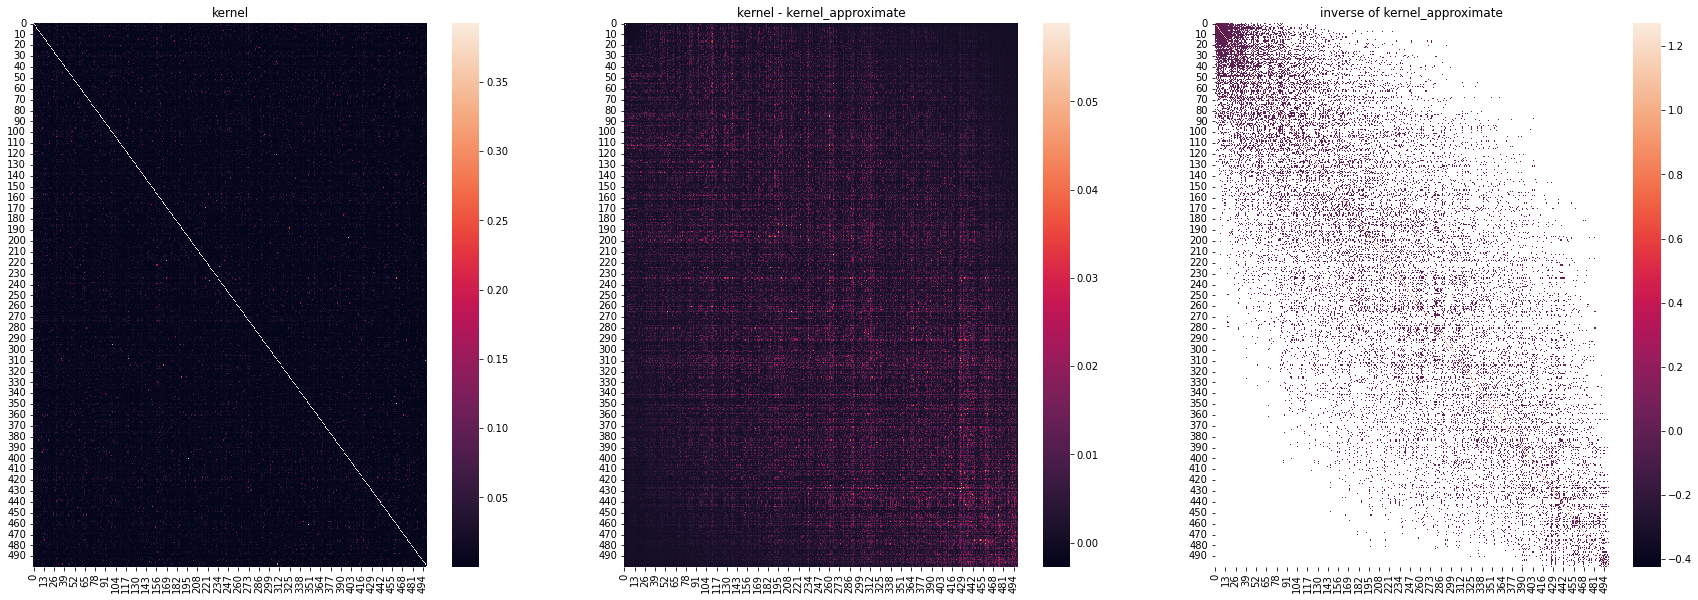

In [5]:

# e.g.
np.random.seed(34)
n_k = 500
p = 8
X = np.random.randint(20, size=(n_k, p))
edsq_mm = get_ed(X)  # calculate once per region 
sorted_index, nnindex = NNmat_lower(X, m = 10) # calculate once per region


theta = 2  # Here we initialize Todo: should be the latest updated value. 
B, H = decompose_kernel_matrix(edsq_mm=edsq_mm, n=n_k, sorted_index=sorted_index, nnindex=nnindex, theta=theta, epsilon=0) #epsilon can only be 0 now... need to debug why the decomposition is not working when epsilon > 0 
C_tilda_inverse = (np.identity(n_k) - B).T @ np.linalg.solve(H, np.identity(n_k)) @ (np.identity(n_k) - B)
# C_tilda_inverse is sparse --> the L.T * L [Cholesky decomposition applied here on C_tilda_inverse]


kernel_mm = get_kernal_similairity(edsq_mm, theta)
a = kernel_mm[sorted_index][:, sorted_index] - np.linalg.solve(C_tilda_inverse, np.identity(n_k))  # Nearest neighborhood is able to approximate the original covariance-matrix calculated by kernel function 


fig, ax = plt.subplots(nrows=1, ncols=3, figsize= (30, 10))
ax = ax.flatten()

sns.heatmap(kernel_mm, mask=(kernel_mm==1), ax= ax[0]).set(title='kernel')


sns.heatmap(a, mask=(a==0), ax=ax[1] ).set(title='kernel - kernel_approximate')

sns.heatmap( C_tilda_inverse , mask = (C_tilda_inverse==0) , ax=ax[2]).set(title='inverse of kernel_approximate')  # indeed C_tilda_inverse is sparse
